### Point Similarity Results: Upsample Anything vs. AnyUP

Upsample Anything method denoises the feature maps and encourages coherent grouping of object regions, leading to tighter object-level binding.


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


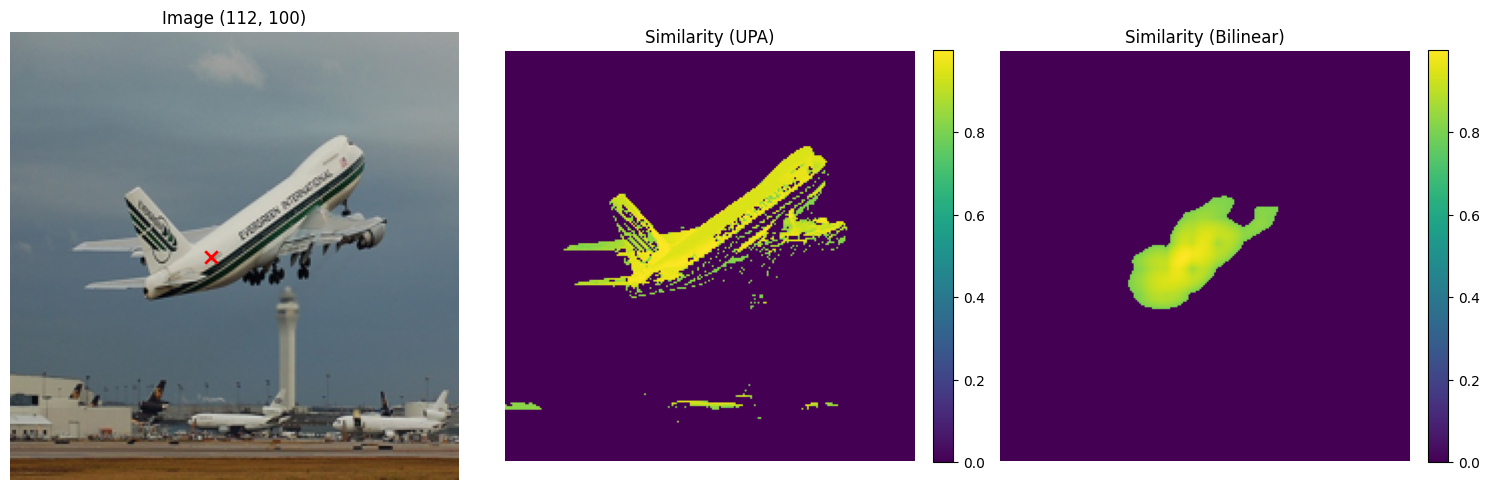

In [35]:
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

from upsample_anything import UPA
from utils import visualize_pca_one

device = "cuda" if torch.cuda.is_available() else "cpu"


def cal_similarity(feat, img, point=(112,112)):
    """
    feat: [1, C, H, W] tensor
    img: PIL image (224,224)
    point: (y, x)
    """
    _, C, H, W = feat.shape
    py, px = point

    # point vector
    v = feat[0, :, py, px]  # [C]

    # normalize
    v_norm = v / (v.norm() + 1e-6)
    feat_norm = feat / (feat.norm(dim=1, keepdim=True) + 1e-6)

    # cosine similarity
    sim = (feat_norm[0] * v_norm[:, None, None]).sum(dim=0).detach().cpu()

    # normalize to 0~1
    sim_np = sim.numpy()
    sim_norm = (sim_np - sim_np.min()) / (sim_np.max() - sim_np.min() + 1e-6)

    return sim_norm


def dinov2_infer(img_path):
    dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device).eval()

    transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
    ])
    
    img = Image.open(img_path).convert("RGB").resize((224, 224))
    img_t = transform(img).unsqueeze(0).to(device, dtype=torch.float32)

    with torch.no_grad():
        feats_list = dinov2_vits14.get_intermediate_layers(img_t, n=1)
        feats_all = feats_list[0].squeeze(0)  # [196, C]

    H = W = int(feats_all.shape[0] ** 0.5)
    feat_map = feats_all.reshape(H, W, -1).permute(2, 0, 1).unsqueeze(0)  # [1,C,14,14]

    return feat_map


if __name__ == "__main__":
    img_path = "airplane2.jpg"
    img = Image.open(img_path).convert("RGB").resize((224, 224), Image.BICUBIC)

    # ▶ DINOv2 feature (14x14)
    lr_feature = dinov2_infer(img_path)

    # ▶ Our method (UPA)
    hr_feature = UPA(img, lr_feature)   # [1, C, 224, 224]

    # ▶ Bilinear upsampling
    bl_feature = F.interpolate(lr_feature, size=(224, 224), mode="bilinear", align_corners=False)

    point = (112, 100)

    # ▶ similarity maps
    sim_upa = cal_similarity(hr_feature, img, point=point)
    sim_bilinear = cal_similarity(bl_feature, img, point=point)

    sim_upa[sim_upa < 0.8] = 0
    sim_bilinear[sim_bilinear < 0.8] = 0

    py, px = point  


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # (1) Image with point
    axes[0].imshow(img)
    axes[0].scatter(px, py, marker='x', s=80, linewidths=2, color='red')
    axes[0].set_title(f"Image ({py}, {px})")
    axes[0].axis("off")

    # (2) UPA similarity
    im1 = axes[1].imshow(sim_upa, cmap="viridis")
    axes[1].set_title("Similarity (UPA)")
    axes[1].axis("off")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # (3) Bilinear similarity
    im2 = axes[2].imshow(sim_bilinear, cmap="viridis")
    axes[2].set_title("Similarity (Bilinear)")
    axes[2].axis("off")
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


### AnyUp

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipykernel_1331/3312000588.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Using cache found in /root/.cache/torch/hub/wimmerth_anyup_main


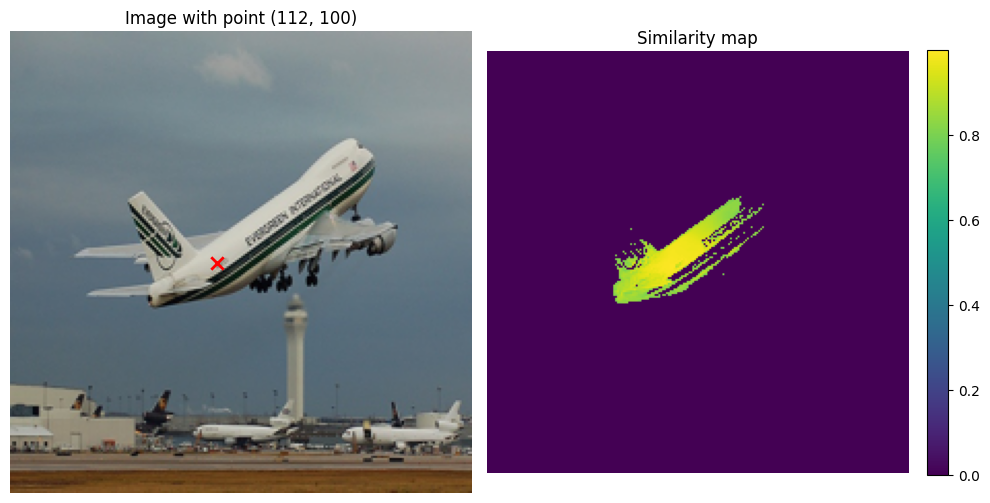

In [33]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np


img_path = "airplane2.jpg"
img = Image.open(img_path).convert("RGB").resize((224, 224), Image.BICUBIC)

lr_feature2 = dinov2_infer(img_path)  


to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),
                         (0.229,0.224,0.225))
])
img_tensor = to_tensor(img).unsqueeze(0).to(device)  # (1,3,224,224)

upsampler = torch.hub.load('wimmerth/anyup', 'anyup').to(device).eval()

with torch.no_grad():
    hr_anyup = upsampler(
        image=img_tensor,        # tensor (1,3,224,224)
        features=lr_feature2,    # (1,C,16,16)
        output_size=(224,224)
    )                           # → (1,384,224,224)

sim_map = cal_similarity(
    hr_anyup,   # [1, C, 224, 224]
    img,          # 
    point=point
)

sim_map[sim_map < 0.8] = 0

py, px = point  
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].scatter(px, py, marker='x', s=80, linewidths=2, color='red')
axes[0].set_title(f"Image with point ({py}, {px})")
axes[0].axis("off")

im = axes[1].imshow(sim_map, cmap="viridis")
axes[1].set_title("Similarity map")
axes[1].axis("off")
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()